# Overhead

### Summary of notebook:

* <b> Golf ball flight dynamics </b>
    * A relatively accurate model for simulating the golf ball trajectory.
* <b> The range-Doppler domain </b>
    * Simulation of range-Doppler measurements.
    * No noise added to process as of yet.
* <b> Multilateration </b>
    * Finding position in $\mathscr{R}^{3}$ from range measurements
    * Notes on least square approximations
* <b> Velocity measurements </b>
    * No (processed) velocity measurements - just numerical differentiation of postion measurements.
    * Actual measurement process to be determined.
* <b> Basic Kalman filter </b>
    * Basic state model
    * Issues with realistic noise on processed measurements.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pylab as plt
from mpl_toolkits import mplot3d
from calc_traj import calc_traj
from range_doppler import *
from kalman_filter import KalmanFilter
from util import *

np.set_printoptions(precision=3)

## Golf ball flight dynamics 
The following section documents the development of a model for golf ball flight dynamics, it is largely based off EMSS's own investigations.

<img src="forces.png" scale=0.25>
<center> <b> Figure 1: Force diagram of a golf ball. $\mathbf{v}$ is the velocity vector and not a force. </b> </center>

Ignoring all external influences, Figure 1 depicts the principle forces acting a golf ball in flight. These forces are assumed to be those with the largest influence on the golf ball's trajectory. The forces are:

* $\mathbf{F}_D$: The drag force is opposed to the velocity $\mathbf{v}$, its magnitude for a given component is determined by $$F_{D} = \frac{1}{2} C_{D} \rho A |v|^{2}$$ $\rho$ is the density of the air and $A$ golf ball's cross sectional area. The drag coefficient, $C_{D}$, is itself a function of both the ball's linear and angular speed. 

* $\mathbf{F}_{L}$: The lift force is perpendicular to linear and rotational velocity, thus determined by a cross product. Its magnitude for a given component is determined by $$F_{L} = \frac{1}{2} C_{L} \rho A |v|^{2}$$ The lift coefficient, $C_{L}$, is itself a function of both the ball's linear and angular speed. 

* $m\mathbf{g}$: Gravity, it goes downwards.

Applying Newton's second law, $$\mathbf{a} = \frac{1}{m} \sum \mathbf{F}$$ and simplifying results in the following system of ODES:

$$ \begin{eqnarray} 
\frac{d^2x}{dt^2} &=& -\frac{\rho A |v|}{2m} (C_{D}v_{x} - C_{L}[\frac{\omega_y}{|\omega|}v_z - \frac{\omega_y}{|\omega|}v_y])  \\  
\frac{d^2y}{dt^2} &=& -g -\frac{\rho A |v|}{2m} (C_{D}v_{y} - C_{L}[\frac{\omega_z}{|\omega|}v_x - \frac{\omega_x}{|\omega|}v_z]) \\ 
\frac{d^2z}{dt^2} &=& -\frac{\rho A |v|}{2m} (C_{D}v_{z} - C_{L}[\frac{\omega_x}{|\omega|}v_y - \frac{\omega_y}{|\omega|}v_x]) 
\end{eqnarray}$$

This system assumes a linear rate of decay for the spin, which is described the following system of equations:

$$ \begin{eqnarray}
\frac{d\omega_x}{dt} &=& -SRD \frac{\omega_x |v|}{R} \\
\frac{d\omega_y}{dt} &=& -SRD \frac{\omega_y |v|}{R} \\
\frac{d\omega_z}{dt} &=& -SRD \frac{\omega_z |v|}{R}
\end{eqnarray} $$

$R$ is the radius of the golf ball.

<b> Remark </b>: <i> It is convention set the $y$-axis as elevation allowing the spin rate to be positive for back spin . This leads to a constant interchange of $y$ and $z$ axes for launch and direction angle calculations; however; this can be abstracted away.</i>

Here SRD, $C_{D}$ and $C_{L}$ are given by their empirical equations:

$$ \begin{eqnarray}
C_{D} &=& C_{D1} + C_{D2} + C_{D3} \sin(\pi [R_{e} - A_{1}]/A_{2}) \\
R_{e} &=& \frac{\rho |v| L}{\mu} \\
C_{L} &=& C_{L1} S^{0.45} \\
SRD &=& R_{1} S \\
S &=& \frac{ |\omega| R}{|v|}
\end{eqnarray} $$

It can be seen the drag coefficient depends on the object's shape and Reynolds number, $R_{e}$, and the lift coefficient on the spin rate factor, $S$. The values of the constants $C_{D1}$, $C_{D2}$, $C_{L1}$, $\mu$, $R$, $R_{1}$, $A_{1}$ and $A_{2}$ can be found in the <b>calc_traj.py</b> module.

<b> Remark </b>: <i> EMSS's documentation shows the model is reasonably accurate when compared to the PGA tour measurements; however it requires the subtle tweaking of several parameters which aren't mentioned in the documentation. This model will not be used as the Kalman filter's system model but it will be used to generate the golf ball's simualted trajectory. This trajectory will then be used to simulate range-Doppler measurements which via multilateration will be converted back to its cartesian coordinates.</i>


### Simulation

The system of ODES can be solved using the function <b>calc_traj</b> in the <b>calc_traj.py</b> module. The initial conditions for the various clubs can be found in the <i>clubs.csv</i> file or the table below. The table and plot below document the simulation's results.

In [2]:
names, p0, v0, w0 = load_clubs('clubs.csv')

N = len(names)
t = np.arange(0, 12, 0.001)

<table> 

    <tr>
        <th>Club</th>
        <th>Launch angle ($^{\circ}$)</th>
        <th>Speed (m/s)</th>
        <th>Spin (RPM)</th>
        <th>Maximum height (m)</th>
        <th>Simulated height (m)</th>
        <th>Maximum carry (m)</th>
        <th>Simulated carry (m)</th>
    </tr>
    
    <tr>
        <th>Driver</th>
        <th>10.9</th>
        <th>74.2</th>
        <th>2686</th>
        <th>29.2</th>
        <th>31.37</th>
        <th>251.46</th>
        <th>240.79</th>
    </tr>
    
    <tr>
        <th>3-Wood</th>
        <th>9.2</th>
        <th>70.2</th>
        <th>3655</th>
        <th>27.43</th>
        <th>28.81</th>
        <th>222.20</th>
        <th>230.44</th>
    </tr>
    
    <tr>
        <th>5-Wood</th>
        <th>9.4</th>
        <th>67.5</th>
        <th>4350</th>
        <th>28.35</th>
        <th>29.77</th>
        <th>210.31</th>
        <th>224.44</th>
    </tr>
    
    <tr>
        <th>Hybrid</th>
        <th>10.2</th>
        <th>63.1</th>
        <th>4360</th>
        <th>24.69</th>
        <th>28.22</th>
        <th>193.85</th>
        <th>210.82</th>
    </tr>
    
    <tr>
        <th>3 Iron</th>
        <th>10.2</th>
        <th>63.1</th>
        <th>4360</th>
        <th>24.69</th>
        <th>28.22</th>
        <th>193.85</th>
        <th>210.82</th>
    </tr>
    
    <tr>
        <th>4 Iron</th>
        <th>11.0</th>
        <th>60.9</th>
        <th>4836</th>
        <th>25.60</th>
        <th>27.71</th>
        <th>185.62</th>
        <th>203.88</th>
    </tr>
    
    <tr>
        <th>5 Iron</th>
        <th>12.1</th>
        <th>58.7</th>
        <th>5361</th>
        <th>28.35</th>
        <th>32.94</th>
        <th>177.39</th>
        <th>198.87</th>
    </tr>
    
    <tr>
        <th>6 Iron</th>
        <th>14.1</th>
        <th>56.4</th>
        <th>6231</th>
        <th>27.43</th>
        <th>36.34</th>
        <th>167.33</th>
        <th>190.14</th>
    </tr>
    
    <tr>
        <th>7 Iron</th>
        <th>16.3</th>
        <th>53.3</th>
        <th>7097</th>
        <th>29.26</th>
        <th>33.33</th>
        <th>157.28</th>
        <th>169.26</th>
    </tr>
    
    <tr>
        <th>8 Iron</th>
        <th>18.1</th>
        <th>51.1</th>
        <th>7998</th>
        <th>28.35</th>
        <th>33.33</th>
        <th>146.30</th>
        <th>156.38</th>
    </tr>
    
    <tr>
        <th>9 Iron</th>
        <th>20.4</th>
        <th>48.4</th>
        <th>8647</th>
        <th>27.43</th>
        <th>34.84</th>
        <th>135.33</th>
        <th>140.73</th>
    </tr>
    
    <tr>
        <th>PW</th>
        <th>24.2</th>
        <th>45.3</th>
        <th>9304</th>
        <th>26.52</th>
        <th>35.33</th>
        <th>124.36</th>
        <th>138.71</th>
    </tr>
    
    
</table>

<center> <b>Table 1: A comparison of PGA tour measurements and model outputs for various club types.</b> </center>

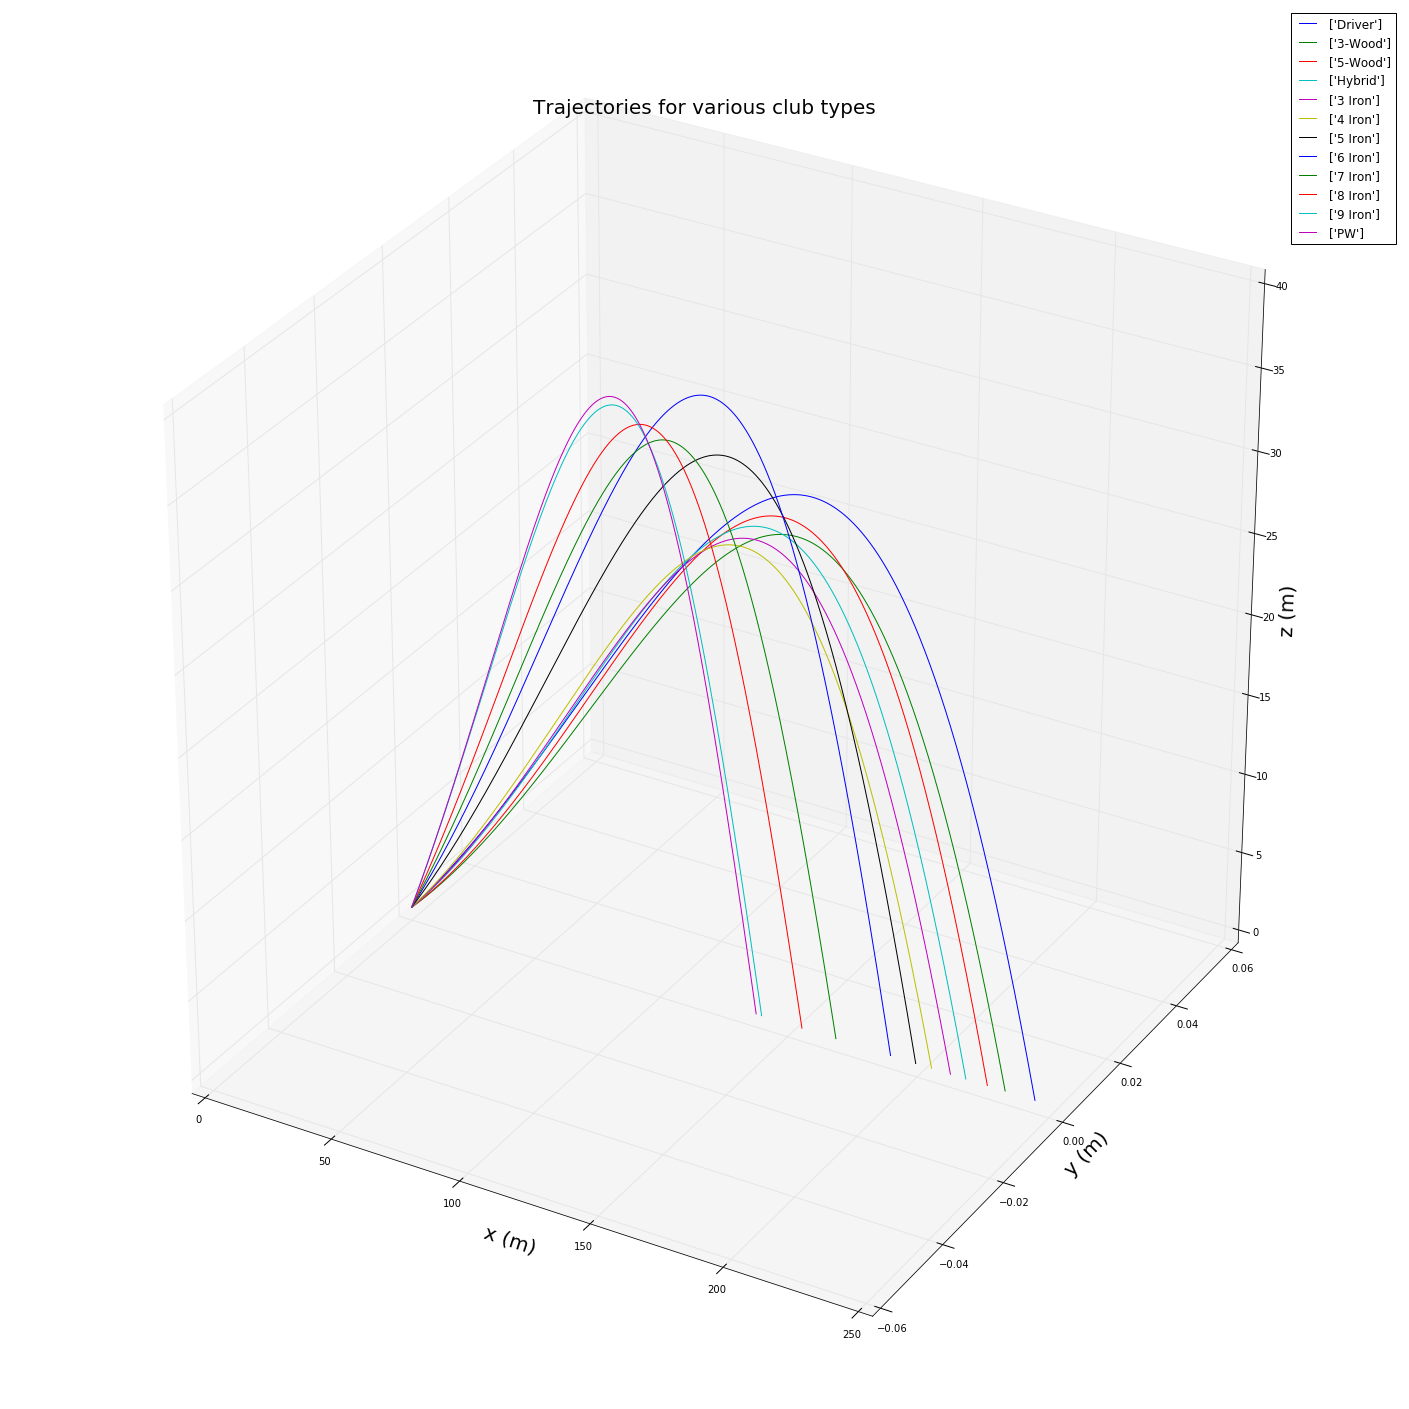

In [3]:
fig  = plt.figure(figsize=(25, 25))
ax = plt.axes(projection='3d')

for i in np.arange(0, N):
    _, f, _ = calc_traj(p0[i, :], v0[i, :], w0[i, :], t)
    ax.plot(f[:, 0], f[:, 1], f[:, 2])
  
ax.set_xlabel('x (m)', fontsize = '20')
ax.set_ylabel('y (m)', fontsize = '20')
ax.set_zlabel('z (m)', fontsize = '20')
ax.set_title('Trajectories for various club types', fontsize = '20')
ax.legend(names)
plt.show()

## The range-Doppler domain

Each of EMSS's sensors will output a range-Doppler map for a given time instance. Rather than simulate this in full, the Doppler information will be approximated by the ball's radial velocity seen by the sensor.

Using the simulation data, the position and velocity, $\mathbf{p}$ and $\mathbf{v}$, of the golf ball are known in full. Therefore the range seen by each sensor for each time step, $r_{k, i}$, is given by:

$$ \begin{eqnarray}
r_{k,i} = |\mathbf{p} - \mathbf{s}_k|
\end{eqnarray}$$

Where $\mathbf{s}_k$ is the known vector position of a given sensor. The radial velocity, $v_{k, i}$ seen by each sensor is determined as follows:
$$ \begin{eqnarray}
\mathbf{u}_{k,i} &=& \frac{\mathbf{p} - \mathbf{s}_k}{r_{k,i}} \\
v_{k, i} &=& \mathbf{u}_{k,i} \cdot \mathbf{v}_i
\end{eqnarray}$$

$\mathbf{u}_{k,i}$ is the unit vecotr from a sensor $k$ to the ball's current position.

### Simulation

The function <b> range_doppler </b> in <b> range_doppler.py </b> determines the range and radial velocity of the ball seen by each sensor. The range-Doppler plot below does not reflect an actual map as it plots the entire trajectory.

<b> Remark </b>: <i> Here I treated CPI (Coherent Processing Interval) as sensor sampling period, it seems to be what EMSS did. The sensor locations were also borrowed from EMSS's documentation, so I assume they reflect reality is some small way. Note the radial velocity is unneeded for the multilateration process, as it only requires range measurements, but was included for completeness. </i>

In [4]:
sensor_locations = np.array([[-10, 28.5, 1], [-15, 30.3, 3],
                             [200, 30, 1.5], [220, -31, 2],
                             [-30, 0, 0.5], [150, 10, 0.6]])
cpi = 40e-3
t_sim = np.arange(0, 12, cpi)
t, p, v = calc_traj(p0[0, :], v0[0, :], w0[0, :], t_sim)

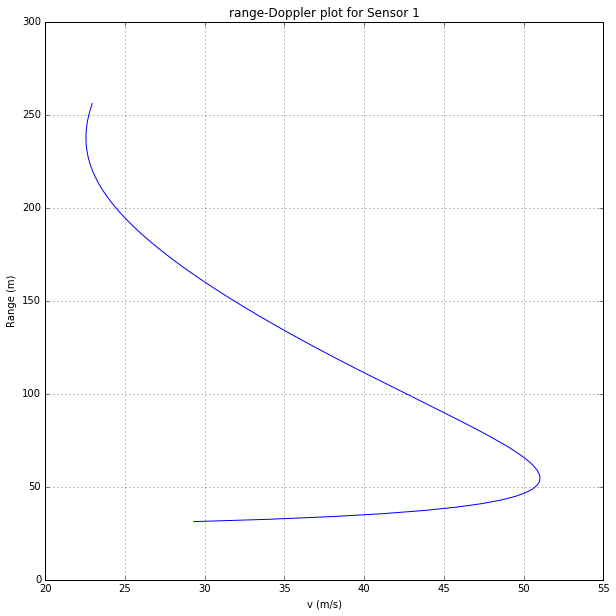

In [5]:
r_d = range_doppler(sensor_locations, p, v)

plt.figure(figsize= (10, 10))
plt.plot(r_d[0, :, 0], r_d[0, :, 1])
plt.xlabel('v (m/s)')
plt.ylabel('Range (m)')
plt.grid(True)
plt.title('range-Doppler plot for Sensor 1')

## Multilateration

There are two main techniques used for range based localization in sensor networks; trilateration and multilateration. Multilateration is derived from trilateration, but is capable of accurate localization when plagued by measurement noise. The following mathematical derivation is hoisted from <a href="#santos">[1]</a> .</i>

### Trilateration

Trilateration is the process of finding a node in space, given certain known anchor points. Assume the positions of the anchor points are defined by vectors $\mathbf{n}_0, \mathbf{n}_1, \mathbf{n}_1 \in \mathscr{R}^2$. An unkown point, $\mathbf{p} \in \mathscr{R}^2$, is at a known distance $d_{i}$ from each anchor point, therefore:

$$ \begin{eqnarray}
d_{0}^{2}  &=& |\mathbf{p} - \mathbf{n}_{0}| &=& |\mathbf{p}|^{2} - 2 \mathbf{p} \cdot \mathbf{n}_{0} + |\mathbf{n}_{0}|^{2} \\
d_{1}^{2} &=&  |\mathbf{p} - \mathbf{n}_{1}| &=& |\mathbf{p}|^{2} - 2 \mathbf{p} \cdot \mathbf{n}_{1} + |\mathbf{n}_{1}|^{2} \\
d_{2}^{2} &=&  |\mathbf{p} - \mathbf{n}_{2}| &=& |\mathbf{p}|^{2} - 2 \mathbf{p} \cdot \mathbf{n}_{2} + |\mathbf{n}_{2}|^{2} \\
\end{eqnarray} $$
Subtracting the second and third equations from the first, yields:
$$ \begin{eqnarray}
2(\mathbf{n}_{1} - \mathbf{n}_{0}) \cdot \mathbf{p} = d_{0}^{2} - d_{1}^{2} - |\mathbf{n}_{0}|^{2} + |\mathbf{n}_{1}|^{2} \\
2(\mathbf{n}_{2} - \mathbf{n}_{0}) \cdot \mathbf{p} = d_{0}^{2} - d_{2}^{2} - |\mathbf{n}_{0}|^{2} + |\mathbf{n}_{2}|^{2} \\
\end{eqnarray} $$

Which can be rewritten in matrix form:

$$ \begin{eqnarray}
\mathbf{A} &=& \begin{bmatrix}
\mathbf{n}_{1} - \mathbf{n}_{0} \\
\mathbf{n}_{2} - \mathbf{n}_{0}
\end{bmatrix}_{2x2} \\
\mathbf{b} &=& \begin{bmatrix}
d_{0}^{2} - d_{1}^{2} - |\mathbf{n}_{0}|^{2} + |\mathbf{n}_{1}|^{2} \\
d_{0}^{2} - d_{2}^{2} - |\mathbf{n}_{0}|^{2} + |\mathbf{n}_{2}|^{2}
\end{bmatrix}_{2x1} \\
2 \mathbf{A} \cdot \mathbf{p} &=& \mathbf{b}
\end{eqnarray} $$

In general, to determine $\mathbf{p} \in \mathscr{R}^{N}$, $N+1$ anchor points are required $\mathbf{n}_{0}, ..., \mathbf{n}_{N} \in \mathscr{R}^{N}$. The geometric constraints are still satisfied with $|\mathbf{p} - \mathbf{n}_{i}|^2 = d_{i}^{2}$, $i = {0, 1, .. , N}$ and by a similiar process to that presented here will result in $N$ linear equations.

### Multilateration

Trialateration asssumes perfect measurements, whereas multilateration can account for error by making use of $M+1$ anchor points in $\mathscr{R}^{N}$, $M > N$. Using the similiar constraints to trilateration, $|\mathbf{p} - \mathbf{n}_{i}|^2= d_{i}^{2}$, $i = {0, 1, .. , M}$ a system of $M$ linear equations are derived:

$$ \begin{eqnarray}
\mathbf{A} &=& \begin{bmatrix}
\mathbf{n}_{1} - \mathbf{n}_{0} \\
\dots \\
\mathbf{n}_{M} - \mathbf{n}_{0}
\end{bmatrix}_{MxN} \\
\mathbf{b} &=& \begin{bmatrix}
d_{0}^{2} - d_{1}^{2} - |\mathbf{n}_{0}|^{2} + |\mathbf{n}_{1}|^{2} \\
\dots \\
d_{0}^{2} - d_{M}^{2} - |\mathbf{n}_{0}|^{2} + |\mathbf{n}_{M}|^{2}
\end{bmatrix}_{Mx1}\\
2 \mathbf{A} \cdot \mathbf{p} &=& \mathbf{b}
\end{eqnarray} $$

As defined $M > N$, therfore this system is overdetermined. Luckily a least squares solution provides an accurate approximate for $\mathbf{p}$, whereas trilateration will produce significant error. The best estimate of $\mathbf{p}$ can be provided by first using QR-decompostion:

$$ \begin{eqnarray}
2 \mathbf{A} \cdot \mathbf{p} &=& \mathbf{b} \\
2 \mathbf{QR} \cdot \mathbf{p} &=& \mathbf{b} \\
2 \mathbf{R} \cdot \mathbf{p} &=& \mathbf{Q}^{T} \cdot \mathbf{b}
\end{eqnarray}$$

Here $\mathbf{Q}$ is orthonormal, $\mathbf{Q}^{T} \mathbf{Q} = \mathbf{I}$. This manipulation minimizes the error, $|2\mathbf{A} \cdot \mathbf{p} - \mathbf{b}|$, providing the best estimate for $\mathbf{p}$.

### Least Squares Approximation derivation

For any general, consistent system of equations:

$$\mathbf{A}_{m \times n} \mathbf{x}_{n \times 1} = \mathbf{b}_{m \times 1}$$

If there is a solution, $\mathbf{b}$ is then simply a linear combination of the columns of $\mathbf{A}$. If $\mathbf{A} = \begin{bmatrix} \mathbf{c_{1}} & \cdots & \mathbf{c_{n}} \end{bmatrix}$, $\mathbf{c}_{i} \in \mathscr{R}^{m}$, then $\mathbf{b} = \sum^{n}_{i=1}x_{i} \mathbf{c}_{i}$. $\mathbf{b}$ is therefore an element in the vector space spanned by the columns of $\mathbf{A}$. This column space, $C(\mathbf{A})$, is a plane through the origin in $\mathscr{R}^{m}$ with the linearly dependent columns $\mathbf{A}$ serving as it basis, therefore its dimension is the rank, $r$, of $\mathbf{A}$. If $\mathbf{b}$ is in $C(\mathbf{A})$ there must be a solution for $\mathbf{x}$ as $\mathbf{x}$ describes the combination of the columns required to produce $\mathbf{b}$. 

<b> Remark </b>: <i> In general, $\mathbf{x} = \mathbf{x}_p + \mathbf{x}_n$, where $\mathbf{x}_n$ are some combination of the vectors in the nullspace, $N(\mathbf{A})$. However in the case of multilateration the rank of $\mathbf{A}$ is $n$ and therefore only produces a trivial nullspace (only the zero vector) and $\mathbf{x} = \mathbf{x}_p$.</i>

The idea of $\mathbf{b}$ fitting perfectly into $C(\mathbf{A})$ is all well and good in theory, but what about practice? If $\mathbf{b}$ is measured data, there will multiple measurements $m>n$ and they will be unique such that $r = n$. $\mathbf{b}$ will almost always be corrupted by noise and be independent from the columns of $\mathbf{A}$, it will lie outside the column space's plane, leading to an inconsistent system of equations with no solution. So how to proceed? Solve the closest problem.

#### Finding a projection matrix

As mentioned before only vectors within the column space will solve this system, therefore necessary find the best approximate, $\mathbf{p}$, of $\mathbf{b}$ within $C(\mathbf{A})$. The system is now approximated by:

$$ \begin{eqnarray} 
\mathbf{A} \mathbf{\hat{x}} &=& \mathbf{p} \\
\mathbf{p} &=& \mathbf{P} \mathbf{b}
\end{eqnarray}$$

$\mathbf{\hat{x}}$ is our approximate solution and $\mathbf{p}$ is the projection of $\mathbf{b}$ onto the plane through the projection matrix $\mathbf{P}$. It is now our job to find the best possible $\mathbf{P}$, which minimizes the error between $\mathbf{p}$ and $\mathbf{b}$,

$$ \begin{eqnarray}
\mathbf{e} &=& \mathbf{b} - \mathbf{p} \\
&=& \mathbf{b} - \mathbf{A} \mathbf{\hat{x}} 
\end{eqnarray}$$

Mimimizing the total error,

$$\begin{eqnarray}
||\mathbf{e}|| &=& (\mathbf{b} - \mathbf{A} \mathbf{\hat{x}})^{T}(\mathbf{b} - \mathbf{A} \mathbf{\hat{x}})
\\
&=& \mathbf{b} \mathbf{b}^{T} - \mathbf{b}^{T} \mathbf{A} \mathbf{\hat{x}} - \mathbf{\hat{x}}^{T} \mathbf{A}^{T} \mathbf{b} - \mathbf{\hat{x}}^{T} \mathbf{A} \mathbf{A}^{T} \mathbf{\hat{x}}\\
\frac{\partial ||\mathbf{e}||}{\partial \mathbf{\hat{x}}} &=& - 2 \mathbf{b}^{T} \mathbf{A} + 2 \mathbf{\hat{x}}^{T}  \mathbf{A}^{T} \mathbf{A} = \mathbf{0} \\
\mathbf{0} &=& -2 ( \mathbf{b}^{T} - \mathbf{\hat{x}}^{T} \mathbf{A}^{T} ) \mathbf{A} \\
\mathbf{0} &=& -2 \mathbf{e}^{T} \mathbf{A} \\
\mathbf{0}^{T} &=& ( \mathbf{e}^{T} \mathbf{A} )^{T} \\
\mathbf{0} &=& \mathbf{A}^{T} \mathbf{e} \\
\end{eqnarray}$$

<b>Remark</b>: <i> This is like minimizing energy, I assume there is no maximum error. This isn't particularly important, but it is nice to see a perdendicular projection come out so naturally. </i>

The energy will be minimized when $\mathbf{e}$ is perdendicular to every column of $\mathbf{A}$, this means $\mathbf{e}$ should be perpendicular to the plane spanned by $C(\mathbf{A})$ (and thus it is in the left nullspace of $\mathbf{A}$, $N(\mathbf{A}^{T})$). This gives:

$$ \begin{eqnarray}
\mathbf{A}^{T} \mathbf{e} &=& \mathbf{0} \\
\mathbf{c}_{1}^{T} \mathbf{e} &=& 0 \\
\cdots \\
\mathbf{c}_{n}^{T} \mathbf{e} &=& 0 \\
\end{eqnarray} $$

From this, 

$$ \begin{eqnarray}
\mathbf{A}^{T} ( \mathbf{b} - \mathbf{A} \mathbf{\hat{x}} ) &=& \mathbf{0} \\
\mathbf{A}^{T} \mathbf{A} \mathbf{\hat{x}} &=& \mathbf{A}^{T} \mathbf{b} \\
\mathbf{\hat{x}} &=& (\mathbf{A}^{T} \mathbf{A})^{-1} \mathbf{A}^{T} \mathbf{b} \\ 
\mathbf{A} \mathbf{\hat{x}} &=& \mathbf{A} (\mathbf{A}^{T} \mathbf{A})^{-1} \mathbf{A}^{T} \mathbf{b} \\ 
\mathbf{p} &=&  \mathbf{A} (\mathbf{A}^{T} \mathbf{A})^{-1} \mathbf{A}^{T} \mathbf{b}
\end{eqnarray} $$

We have now found our projection matrix $\mathbf{P} =  \mathbf{A} (\mathbf{A}^{T} \mathbf{A})^{-1} \mathbf{A}^{T} \mathbf{b}$.

<b> Remark </b>: <i> If have $\mathbf{A}$ has linearly dependent columns as we have assumed $\mathbf{A}^{T}\mathbf{A}$ will be invertible. In fact it will be positive definite, one of the best possible types matrix. </i>

#### Solving the system

After projecting $\mathbf{b}$ onto the $C(\mathbf{A})$ plane we are left with the following system:

$$ \begin{eqnarray} 
\mathbf{A} \mathbf{\hat{x}} &=& \mathbf{p} \\
\mathbf{A} \mathbf{\hat{x}} &=& \mathbf{A} (\mathbf{A}^{T} \mathbf{A})^{-1} \mathbf{A}^{T} \mathbf{b} \\
\mathbf{A}^{T} \mathbf{A} \mathbf{\hat{x}} &=& \mathbf{A}^{T}  \mathbf{A} (\mathbf{A}^{T} \mathbf{A})^{-1} \mathbf{A}^{T} \mathbf{b} \\
\mathbf{A}^{T} \mathbf{A} \mathbf{\hat{x}} &=&  \mathbf{A}^{T} \mathbf{b}
\end{eqnarray}$$

As mentioned before $\mathbf{A}$ has $n$ independent columns and therefore $\mathbf{A}^{T} \mathbf{A}$ is positive definite and the system has a unique solution.

<b> Remark </b>: <i> You may notice this final result was already reached in steps leading up to the projection matrix. I prefer projecting $\mathbf{b}$ then simpliying the resulting system, it just makes more sense to me. </i>

#### But wait, there's more!

You have notice in the formal explanation of multilateration I multiply by some orthonormal matrix, $\mathbf{Q}^{T}$, instead of by $\mathbf{A}^{T}$. This is done by choosing an orthonormal basis for the column space as it greatly simplifies the projection matrix:

$$\begin{eqnarray}
\mathbf{P} &=& \mathbf{Q} (\mathbf{Q}^T \mathbf{Q})^{-1} \mathbf{Q}^{T} \mathbf{b} \\
&=& \mathbf{Q} \mathbf{Q}^{T} \mathbf{b} \\
\end{eqnarray}$$

Exploiting $\mathbf{QR}$ decomposition we can solve a much simpler system:

$$\begin{eqnarray}
\mathbf{A} \mathbf{\hat{x}} &=& \mathbf{Q} \mathbf{Q}^{T} \mathbf{b} \\
\mathbf{Q} \mathbf{R} \mathbf{\hat{x}} &=& \mathbf{Q} \mathbf{Q}^{T} \mathbf{b} \\
\mathbf{Q}^{T} \mathbf{Q} \mathbf{R} \mathbf{\hat{x}} &=& \mathbf{Q}^{T} \mathbf{Q} \mathbf{Q}^{T} \mathbf{b} \\
\mathbf{R} \mathbf{\hat{x}} &=& \mathbf{Q}^{T} \mathbf{b} \\
\end{eqnarray} $$

Whether doing $\mathbf{QR}$ decomposition is more efficient than simply mutliplying by the transpose of a known matrix is mystery to me, but whatever.

<b> Remark </b>: <i> The term orthonormal is usually reserved for square matrices, $\mathbf{Q}$ in this case is rectangular with orthormal columns, but we only have so much time. $\mathbf{Q}^{T}$ is $\mathbf{Q}$'s left inverse. </i>

<b>Remark</b>: <i> At this point you should be thoroughly convinced my derivations aren't worth reading. They are done more so to reinforce my understanding of the linear algebra, which is flaky at best. </i>

## Implementation

The function <b>multilateration</b> in <b>range_doppler</b> determines the golf ball's coordinates in $\mathscr{R}^{3}$. The result for a single club is plotted below.

<b> Remark </b>: <i> As of yet no measurement noise has been introduced and this result should be equivalent to trilateration. As it can be seen from the derivation the clocks on each sensor must be synchronized, hopefully EMSS's system accounts for this.</i>

In [6]:
p_m = multilateration(sensor_locations, r_d[:, :, 1])

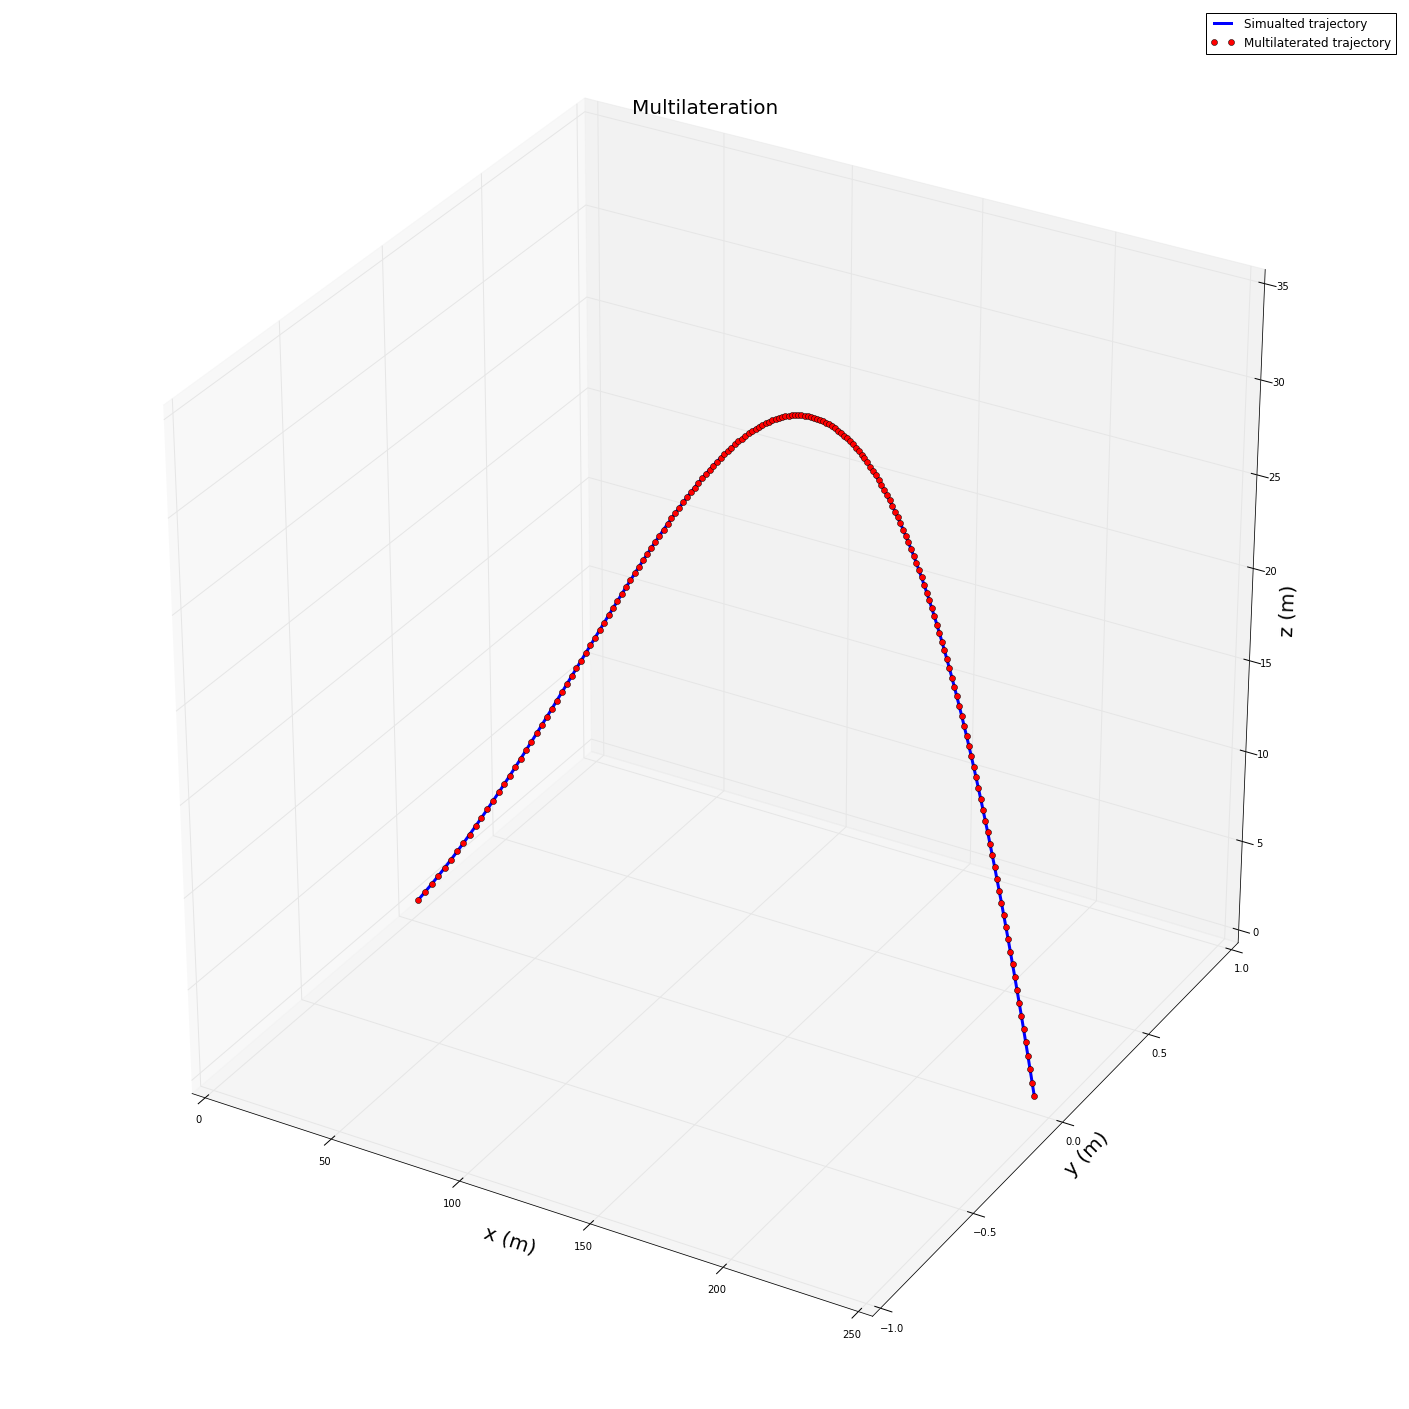

In [7]:
fig  = plt.figure(figsize=(25, 25))
ax = plt.axes(projection='3d')
ax.plot(p_m[:, 0], p_m[:, 1], p_m[:, 2], linewidth=3.0)
ax.plot(p[:, 0], p[:, 1], p[:, 2], 'or')
ax.set_xlabel('x (m)', fontsize = '20')
ax.set_ylabel('y (m)', fontsize = '20')
ax.set_zlabel('z (m)', fontsize = '20')
ax.set_title('Multilateration', fontsize = '20')
ax.set_ylim([-1, 1])
ax.legend(['Simualted trajectory', 'Multilaterated trajectory'])
plt.show()

## Velocity measurements

To swiftly move ahead with Kalman filter implementation, I have decided to neglect the linear velocity derivation. The velocity is simply determined by numerically differentiating the position, $\mathbf{p}$, according to time, $\mathbf{t}$.

In [8]:
v_m = determine_velocity(t, p_m, r_d[:, :, 0])

## Kalman Filtering

A Kalman Filter object was created which implements the basic linear Kalman filter algorithm, as given in <i>Probabilistic Robotics</i> <a href="#pr_ch2">[2]</a>, <a href="#pr_ch3">[3]</a>.

<b> Remark: </b> <i> This documentation was done quickly and is terrible. I've tried to remain consistent with <i>Probablistic Robotics'</i> terminology and notation, but it hasn't always worked out. </i>

### State transition probability

The state transistion probability, $p(\mathbf{x}_{t} \left.|\right. \mathbf{u}_{t}, \mathbf{x}_{t-1})$, is linear function in its arguments with added Gaussian noise:

$$\mathbf{x}_{t} = \mathbf{A}_t \mathbf{x}_{t-1} + \mathbf{B}_{t} \mathbf{u}_{t} + \mathbf{\epsilon}_t$$

Where, 
* $\mathbf{x}_{t}$ is the $nx1$ <i>state vector<i>.
* $\mathbf{u}_{t}$ is the $mx1$ <i>control vector<i>.
* $\mathbf{A}_{t}$ is the $nxn$ <i>state transistion matrix</i>.
* $\mathbf{B}_{t}$ is the $nxm$ <i>control matrix<i>.
* $\mathbf{\epsilon}_{t}$ is the $nx1$ <i>noise vector<i>, modelling the uncertainty introduced by state transition with a zero mean Gaussian with a covariance $\mathbf{R}_{t}$.

As we are only tracking the golf ball, both the state transistion and control matrices will be used to model the system. For a first attempt a very basic model will be used to describe the system, ommiting all areodynamical contrivances. The state transition will be described the following system:

$$\begin{eqnarray}
x_{t} &=& x_{t-1} +  \dot{x}_{t-1} t \\ 
\dot{x}_{t} &=& \dot{x}_{t-1} \\ 
y_{t} &=& y_{t-1} +  \dot{y}_{t-1} t \\ 
\dot{y}_{t} &=& \dot{y}_{t-1} \\ 
z_{t} &=& z_{t-1} +  \dot{z}_{t-1} t  - \frac{1}{2} g t^{2}\\ 
\dot{z}_{t} &=& \dot{z}_{t-1} - g t\\ 
\end{eqnarray}$$

This can be written in matrix form, as:

\begin{eqnarray}
\begin{bmatrix}
x_{t}  \\
\dot{x}_{t} \\
y_{t} \\
\dot{y}_{t} \\
z_{t} \\
\dot{z}_{t} \\
\end{bmatrix} &=&
\begin{bmatrix}
1 & 1 & 0 & 0 & 0 & 0   \\
0 & 1 & 0 & 0 & 0 & 0   \\
0 & 0 & 1 & 1 & 0 & 0   \\
0 & 0 & 0 & 1 & 0 & 0   \\
0 & 0 & 0 & 0 & 1 & 1   \\
0 & 0 & 0 & 0 & 0 & 1   \\
\end{bmatrix}
\begin{bmatrix}
x_{t-1}  \\
\dot{x}_{t-1} \\
y_{t-1} \\
\dot{y}_{t-1} \\
z_{t-1} \\
\dot{z}_{t-1} \\
\end{bmatrix} +
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0   \\
0 & 0 & 0 & 0 & 0 & 0   \\
0 & 0 & 0 & 0 & 0 & 0   \\
0 & 0 & 0 & 0 & 0 & 0   \\
0 & 0 & 0 & 0 & 1 & 0   \\
0 & 0 & 0 & 0 & 0 & 1   \\
\end{bmatrix}
\begin{bmatrix}
0 \\
0 \\
0 \\
0 \\
- \frac{1}{2} g t^{2} \\
- g t \\
\end{bmatrix} \\
\mathbf{x}_{t} &=& \mathbf{A}_t \mathbf{x}_{t-1} + \mathbf{B}_{t} \mathbf{u}_{t}
\end{eqnarray}

With the $\mathbf{x}_{t}$, $ \mathbf{u}_{t}$, $\mathbf{A}_t$ and $\mathbf{B}_{t}$ in place, all that remains is to define $\mathbf{\epsilon}_{t}$'s covariance matrix, $\mathbf{R}_t$:

$$\mathbf{R}_{t} = 
\begin{bmatrix}
\sigma_{r}^{2} & 0 & 0 & 0 & 0 & 0   \\
0 & \sigma_{r}^{2}   & 0 & 0 & 0 & 0   \\
0 & 0 & \sigma_{r}^{2}   & 0 & 0 & 0   \\
0 & 0 & 0 & \sigma_{r}^{2} & 0 & 0   \\
0 & 0 & 0 & 0 & \sigma_{r}^{2}   & 0   \\
0 & 0 & 0 & 0 & 0 & \sigma_{r}^{2}   \\
\end{bmatrix} $$

Here $\sigma_{r}^{2}$ is some appropriate variance.

<b> Remark </b>: <i> Defining the covaraince as such keeps the noise for each 'state variable' independent, but I am not sure if this is the correct approach. Sure is easy though. </i>

### State transition probability

The measurement probability, $p(\mathbf{z}_t | \mathbf{x}_t)$, is also linear in arguments, with added Gussian noise:

$$ \mathbf{z}_t = \mathbf{C}_t \mathbf{x}_t + \mathbf{\delta}_t $$

Where,
* $\mathbf{z}_t$ is the $kx1$ observation vector.
* $\mathbf{C}_t$ is the $kxn$ <i> process measurement matrix</i>.
* $\mathbf{x}_t$ is the $nx1$ <i> state vector</i>.
* $\mathbf{\delta}_t$ is the $kx1$ <i> measurement noise vector</i>, with zero mean and covariance matrix $\mathbf{Q}_t$.

As the state only contains information about the ball's position and velocity and these can be 'directly' measured, $\mathbf{C}_t$ is simply an identity matrix:

\begin{eqnarray}
\begin{bmatrix}
z_{x_{t}}  \\
z_{\dot{x}_{t}} \\
z_{y_{t}} \\
z_{\dot{y}_{t}} \\
z_{z_{t}} \\
z_{\dot{z}_{t}} \\
\end{bmatrix} &=&
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0   \\
0 & 1 & 0 & 0 & 0 & 0   \\
0 & 0 & 1 & 0 & 0 & 0   \\
0 & 0 & 0 & 1 & 0 & 0   \\
0 & 0 & 0 & 0 & 1 & 0   \\
0 & 0 & 0 & 0 & 0 & 1   \\
\end{bmatrix}
\begin{bmatrix}
x_{t}  \\
\dot{x}_{t} \\
y_{t} \\
\dot{y}_{t} \\
z_{t} \\
\dot{z}_{t} \\
\end{bmatrix} \\
\mathbf{z}_{t} &=& \mathbf{C}_t \mathbf{x}_{t}
\end{eqnarray}

The covariance matrix $\mathbf{Q}_t$, through similar motivation to $\mathbf{R}_t$, is:

$$\mathbf{Q}_{t} = 
\begin{bmatrix}
\sigma_{q}^{2} & 0 & 0 & 0 & 0 & 0   \\
0 & \sigma_{q}^{2}   & 0 & 0 & 0 & 0   \\
0 & 0 & \sigma_{q}^{2}   & 0 & 0 & 0   \\
0 & 0 & 0 & \sigma_{q}^{2} & 0 & 0   \\
0 & 0 & 0 & 0 & \sigma_{q}^{2}   & 0   \\
0 & 0 & 0 & 0 & 0 & \sigma_{q}^{2}   \\
\end{bmatrix} $$

The code below intialises the variables for the Driver club, the values of $\sigma_{r}^{2}$ and $\sigma_{q}^{2}$ vary according to mood.

In [9]:
N = 6
M, _ = p_m.shape

dt = cpi
g = 9.81

sigma_r = 2.5
sigma_q = 0.1

In [10]:
A_t = np.identity(N)
A_t[0, 1] = A_t[2, 3] = A_t[4, 5] = dt 

B_t = np.zeros((N, N))
B_t[4, 4] = B_t[5, 5] = 1

R_t = np.identity(N)*sigma_r

C_t = np.identity(N)
Q_t = np.identity(N)*sigma_q

In [11]:
mu_0 = np.zeros((N, 1))
mu_0[[1, 3, 5], :] = v[0, :].reshape(3, 1)

sig_0 = np.identity(N)

In [12]:
u_t = np.zeros((6, 1))
u_t[4] = -0.5*g*(dt**2)
u_t[5] = -g*dt

In [13]:
z_t = np.empty((M, N))

z_t[:, [0, 2, 4]] = p_m
z_t[:, [1, 3, 5]] = v_m

### Kalman Filter aglorithm

The <b>KalmanFilter</b> object directly implements the algorithm given in <i> Probabilistic Robotics </i> Chapter 3. The algorithm is now restated:

#### Algorithm Kalman_filter( $\mathbf{\mu}_{t-1}$ ,  $\mathbf{\Sigma}_{t-1}$,  $\mathbf{u}_{t-1}$,   $\mathbf{z}_{t-1}$):

$$\begin{eqnarray}
\mathbf{\bar{\mu}}_{t} &=& \mathbf{A}_{t} \mathbf{\mu}_{t-1} + \mathbf{B}_{t} \mathbf{u}_{t}  \\
\mathbf{\bar{\Sigma}}_{t} &=& \mathbf{A}_{t} \mathbf{\Sigma}_{t-1} \mathbf{A}_{t}^{T} + \mathbf{R}_t \\
\\
\mathbf{K}_t &=& \mathbf{\bar{\Sigma}}_{t} \mathbf{C}_{t}^{T} ( \mathbf{C}_{t} \mathbf{\bar{\Sigma}}_{t-1} \mathbf{C}_{t}^{T} + \mathbf{Q}_{t} )^{-1} \\
\mathbf{\mu}_{t} &=& \mathbf{\bar{\mu}}_{t} + \mathbf{K}_{t} ( \mathbf{z}_{t} - \mathbf{C}_{t} \mathbf{\bar{\mu}}_{t})  \\
\mathbf{\Sigma}_t &=& (\mathbf{I} - \mathbf{K}_t \mathbf{C}_{t}) \mathbf{\bar{\Sigma}}_{t}
\end{eqnarray}$$

#### return $\mathbf{\mu}_{t}$, $\mathbf{\Sigma}_t$

<b> Remark </b>: <i> Nothing clever is done here, the algorithm is implemented as written, inverses are computed directly and so on. </i>

The Kalman filter's estimates are determined by stepping through the processed measurements, $\mathbf{p}_m$ and $\mathbf{v}_m$, and feeding in a constant control vector $\mathbf{u}_t$. 

<b> Remark </b>: <i> As defined above, $\mathbf{u}_t$, is a component of the system model and not a control vector. This choice was made to keep the <b>KalmanFilter</b> object general, or something. </i>

In [14]:
kf = KalmanFilter(A_t, B_t, C_t, R_t, Q_t, mu_0, sig_0)

In [15]:
mu_t = np.empty((M, N))

for i in np.arange(0, M):
    mu_t[i, :] = kf.step(u_t, z_t[i]).reshape((N, ))
    
p_e = mu_t[:, [0, 2, 4]].reshape((M, 3))
v_e = mu_t[:, [1, 3, 5]].reshape((M, 3))

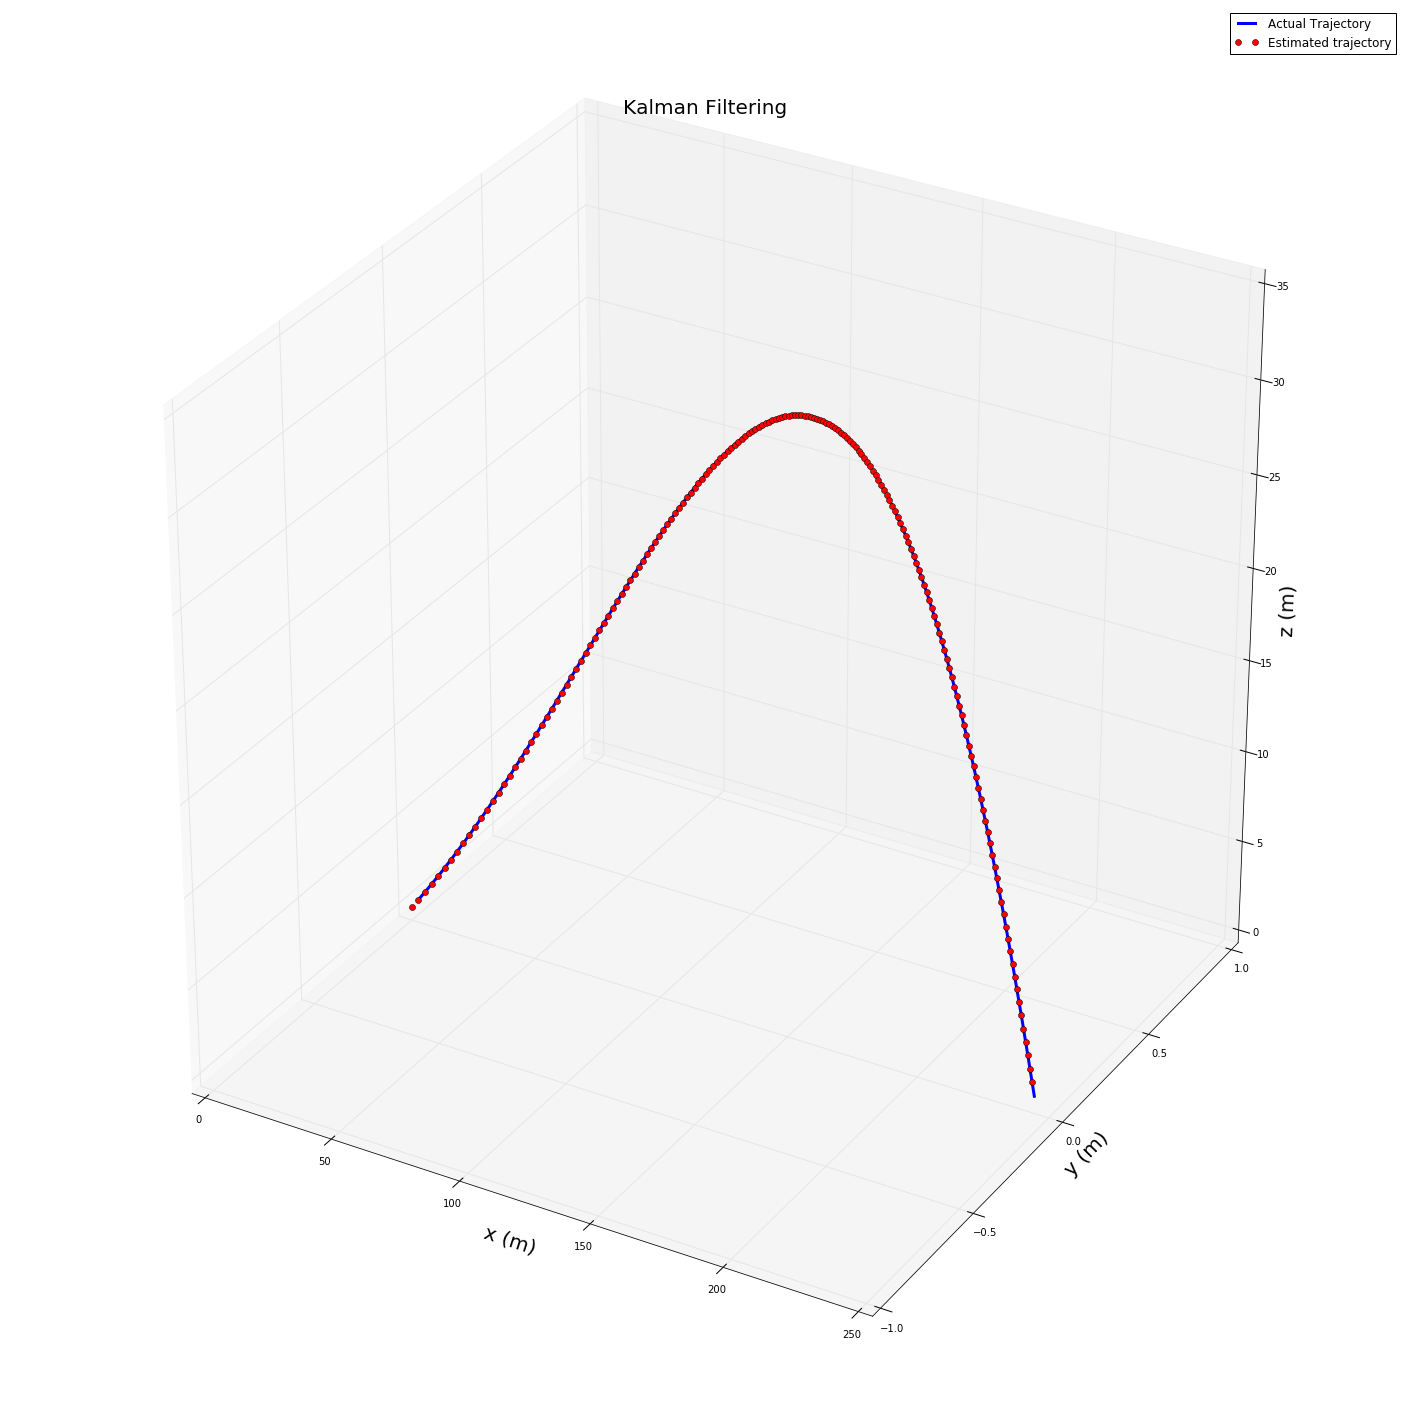

In [16]:
fig  = plt.figure(figsize=(25, 25))
ax = plt.axes(projection='3d')
ax.plot(p[:, 0], p[:, 1], p[:, 2], linewidth=3.0)
ax.plot(p_e[:, 0], p_e[:, 1], p_e[:, 2], 'or')
ax.set_xlabel('x (m)', fontsize = '20')
ax.set_ylabel('y (m)', fontsize = '20')
ax.set_zlabel('z (m)', fontsize = '20')
ax.set_title('Kalman Filtering', fontsize = '20')
ax.set_ylim([-1, 1])
ax.legend(['Actual Trajectory', 'Estimated trajectory'])
plt.show()

## References

<ol type="1">
  <li><a name="santos">F. Santos. <i>"Localization in Wireless Sensor Networks"</i>. <a href="http://web.ist.utl.pt/ist150077/doc/localization.pdf">http://web.ist.utl.pt/ist150077/doc/localization.pdf</a>, 2008 [Feb. 2016]. </a></li>
  
    <li><a name="pr_ch2">Thrun et. al. <i> Probabilistic Robotics</i>. MIT Press, 2005, pp. 13-35.</a></li>
    
    <li><a name="pr_ch3">Thrun et. al. <i> Probabilistic Robotics</i>. MIT Press, 2005, pp. 39-79.</a></li>
    
</ol> 